# best and worst image differences
image difference of negatives with highest anomalyRating and positives with lowest anomalyRating

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("/data/tim/heronWorkspace/src")
sys.path.append("/data/tim/heronWorkspace/0_preProcessing")
sys.path.append("/data/tim/heronWorkspace/1_AE")
sys.path.append("/data/tim/heronWorkspace/2_postProcessing")
sys.path.append("/data/tim/heronWorkspace/")


from AEHeronModel import CAEHeron
from lightning.pytorch.callbacks import ModelSummary
from torchsummary import summary
import HeronImageLoader
from torch.utils.data import DataLoader, BatchSampler
from matplotlib import pyplot as plt
import lightning.pytorch as pl
from lightning.pytorch.tuner import Tuner
import pandas as pd
from lightning.pytorch.loggers import CSVLogger
from models import MLPBasic, CAEBigBottleneck, CAESmallBottleneckWithLinear, MLPBasicHeatMap, CAEV1
import numpy as np
import torch.nn.functional as F
import torch
from torchvision.transforms import GaussianBlur
from PIL import Image, ImageFilter
import random
from scipy.stats import loguniform
from ClassifierDatasets import DatasetThreeConsecutive, UnNormalize
# from torchmetrics.image import StructuralSimilarityIndexMeasure
from skimage.metrics import structural_similarity as ssim
import seaborn as sns
from sklearn.model_selection import ParameterSampler
from scipy.stats import loguniform
import functorch
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve
from PostProcessingHelper import MinFilter, PostProcess, CheckPoints
import glob
from pathlib import Path
import os


colors = [
    "#32829C",
    "#E38538",
    "#51AC8C",
    "#D94841",
    "#7A5C96"
]
sns.set_palette(sns.color_palette(colors))
sns.set_style("whitegrid")

In [8]:
#TODO: include camerProps

def evaluateAndPlotSettings(settings: [dict], checkPoint = None):
    unnorm = UnNormalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
    negVals = {
            "mean": [],
            "std": [],
            "min": [],
            "max": [],
            "median": [],
        }
    posVals = {
        "mean": [],
        "std": [],
        "min": [],
        "max": [],
        "median": [],
    }
    recallArr = []
    precisionArr = []
    imagePaths = []
    allVals = []
    imds = []
    for settingNr, params in enumerate(settings):
        if checkPoint is None:
            checkPoint = '/data/tim/heronWorkspace/logs/CAEV1/version_3/checkpoints/epoch=49-step=19350.ckpt'
        caeLoaded = CAEHeron.load_from_checkpoint(checkPoint, model = CAEV1)
        caeLoaded.freeze()

        dataset = DatasetThreeConsecutive(cameras=params["cameras"], resize_to=CAEV1.imsize, **loaderParams)
        print(f'Length of dataset: {len(dataset)}')
        print(params)
        dataLoader = DataLoader(dataset, batch_size=16, shuffle=False, num_workers=2)

        blur = GaussianBlur(kernel_size=params["gaussianFilterSize"], sigma=params["gaussianFilterSigma"]) #TODO: make this a parameter
        lossFn = F.mse_loss if params["lossFn"] == "MSE" else F.l1_loss
        vals = []
        for (imArr, lblArr, camera, ImagePath) in dataLoader:
            isTrainingCamera = camera in caeLoaded.hparams.cameras
            prevImg = imArr[0] #alwasy #batch_size images
            currImg = imArr[1]
            nextImg = imArr[2]

            prevPred, currPred, nextPred = [unnorm(caeLoaded(x.to(caeLoaded.device))) for x in [prevImg, currImg, nextImg]]
            prevImg, currImg, nextImg = [unnorm(x) for x in [prevImg, currImg, nextImg]]


            prevImgBlurred, currImgBlurred, nextImgBlurred = [blur.forward(x).to(prevPred.device) for x in [prevImg, currImg, nextImg]]
        
            
            prevImd, currImd, nextImd = [torch.sum(lossFn(imgBlurred, pred, reduction='none'), dim=1) for imgBlurred, pred in zip([prevImgBlurred, currImgBlurred, nextImgBlurred], [prevPred, currPred, nextPred])]

            prevToCurrImd = torch.clamp(torch.sub(currImd, prevImd), min= 0)
            nextToCurrImd = torch.clamp(torch.sub(currImd, nextImd), min= 0)

            prevNextCurrImd = torch.div(torch.add(prevToCurrImd, nextToCurrImd), 2)

            minFilter = MinFilter(kernelSize=params["minFilterKernelSize"])
            prevNextCurrImdMin = torch.stack([minFilter(x) for x in prevNextCurrImd]) 
            

            prevNextCurrImdMinThresh = torch.where(prevNextCurrImdMin < params["zeroThreshold"], torch.zeros_like(prevNextCurrImdMin), prevNextCurrImdMin)
            

            sumPrevNextCurrImdMin = torch.sum(prevNextCurrImdMinThresh, dim=(1, 2))
            predictions = (sumPrevNextCurrImdMin> params["sumThreshold"]).to(torch.int)


            for i in range(len(predictions)):
                vals.append([lblArr[i].item(), predictions[i].item(), sumPrevNextCurrImdMin[i].item(), settingNr])
        
            imagePaths += list(ImagePath)
            imds += list(prevNextCurrImdMinThresh.cpu().detach().numpy())
        vals = np.array(vals)
        
        imagePaths = np.array(imagePaths, dtype=object)
        imds = np.array(imds)

        onlyPos = vals[vals[:, 0] == 1]
        onlyNeg = vals[vals[:, 0] == 0]
        print(f'mean pos: {np.mean(onlyPos[:, 2])}, std pos: {np.std(onlyPos[:, 2])}')
        print(f'mean neg: {np.mean(onlyNeg[:, 2])}, std neg: {np.std(onlyNeg[:, 2])}')
        print(f'median pos: {np.median(onlyPos[:, 2])}, median neg: {np.median(onlyNeg[:, 2])}')
        print(f'lowest pos: {np.min(onlyPos[:, 2])}, highest pos: {np.max(onlyPos[:, 2])}')
        print(f'lowest neg: {np.min(onlyNeg[:, 2])}, highest neg: {np.max(onlyNeg[:, 2])}')

        posVals["mean"].append(np.mean(onlyPos[:, 2]))
        posVals["std"].append(np.std(onlyPos[:, 2]))
        posVals["min"].append(np.min(onlyPos[:, 2]))
        posVals["max"].append(np.max(onlyPos[:, 2]))
        posVals["median"].append(np.median(onlyPos[:, 2]))

        negVals["mean"].append(np.mean(onlyNeg[:, 2]))
        negVals["std"].append(np.std(onlyNeg[:, 2]))
        negVals["min"].append(np.min(onlyNeg[:, 2]))
        negVals["max"].append(np.max(onlyNeg[:, 2]))
        negVals["median"].append(np.median(onlyNeg[:, 2]))

        recallArr.append(recall_score(vals[:, 0], vals[:,1]))
        precisionArr.append(precision_score(vals[:, 0], vals[:,1]))

        print(f'accuracy: {accuracy_score(vals[:, 0], vals[:,1])}')
        print(f'precision: {precision_score(vals[:, 0], vals[:,1])}')
        print(f'recall: {recall_score(vals[:, 0], vals[:,1])}')
        print(f'f1: {f1_score(vals[:, 0], vals[:,1])}')
        plt.show()

        # sort by sum of pixel values
        sortInds = (-vals[:, 2]).argsort()
        vals = vals[sortInds]
        imagePaths = imagePaths[sortInds]
        imds = imds[sortInds]
        

        # image plot worst false positives and false negatives
        fig, ax = plt.subplots(3, 4, figsize=(40, 25))
        fig.tight_layout(h_pad=0.1, w_pad=0.1)

        wortFPPath, worstFPImd, worstFPVals = imagePaths[vals[:, 0] == 0], imds[vals[:, 0] == 0], vals[vals[:, 0] == 0]
        wortFNPath, worstFNImd, worstFNVals = imagePaths[vals[:, 0] == 1][::-1], imds[vals[:, 0] == 1][::-1], vals[vals[:, 0] == 1][::-1]

        ax = ax.flatten()
        for i in range(12):
            fpPath = wortFPPath[i]
            ax[i].imshow(worstFPImd[i])
            ax[i].set_title(f"FP: {fpPath}, Sum: {worstFPVals[i, 2]:.2f} True Lbl: {worstFPVals[i, 0]}",size=20)

        fig.suptitle(f'Worst False Positives', fontsize=35, y=1.03)

        for i in range(len(ax)):
            ax[i].set_xticks([])
            ax[i].set_yticks([])
        plt.show()

        fig, ax = plt.subplots(3, 4, figsize=(40, 25))
        fig.tight_layout(h_pad=0.1, w_pad=0.1)
        ax = ax.flatten()
        for i in range(12):
            fnPath = wortFNPath[i]
            ax[i].imshow(worstFNImd[i])
            ax[i].set_title(f"FN: {fnPath}, Sum: {worstFNVals[i, 2]:.2f} True Lbl: {worstFNVals[i, 0]}",size=20)
        fig.suptitle(f'Worst False Negatives', fontsize=35, y=1.03)

        for i in range(len(ax)):
            ax[i].set_xticks([])
            ax[i].set_yticks([])
        plt.show()

        
        
        allVals.append(vals)
        vals = []
        imagePaths = []


/data/tim/heronWorkspace/manuallyClassified/manuallyClassifiedSGN1.csv not found
you must manually classify some images first to use the manual validation mode
skipping the camera: SGN1
Length of dataset: 450
{'cameras': ['GBU1', 'GBU4', 'KBU2', 'PSU1', 'PSU2', 'PSU3', 'SGN1', 'SBU3'], 'balanced': True, 'distinctCAETraining': False, 'gaussianFilterSize': 5, 'gaussianFilterSigma': 5, 'filter': 'MinFilter', 'minFilterKernelSize': 4, 'zeroThreshold': 0.2, 'sumThreshold': 20, 'lossFn': 'L1'}
mean pos: 34.13932256148921, std pos: 78.36783460748161
mean neg: 10.88254250632392, std neg: 31.55372619298344
median pos: 9.422903060913086, median neg: 0.4499088227748871
lowest pos: 0.0, highest pos: 700.4115600585938
lowest neg: 0.0, highest neg: 275.61822509765625
accuracy: 0.6111111111111112
precision: 0.7403846153846154
recall: 0.3422222222222222
f1: 0.4680851063829787


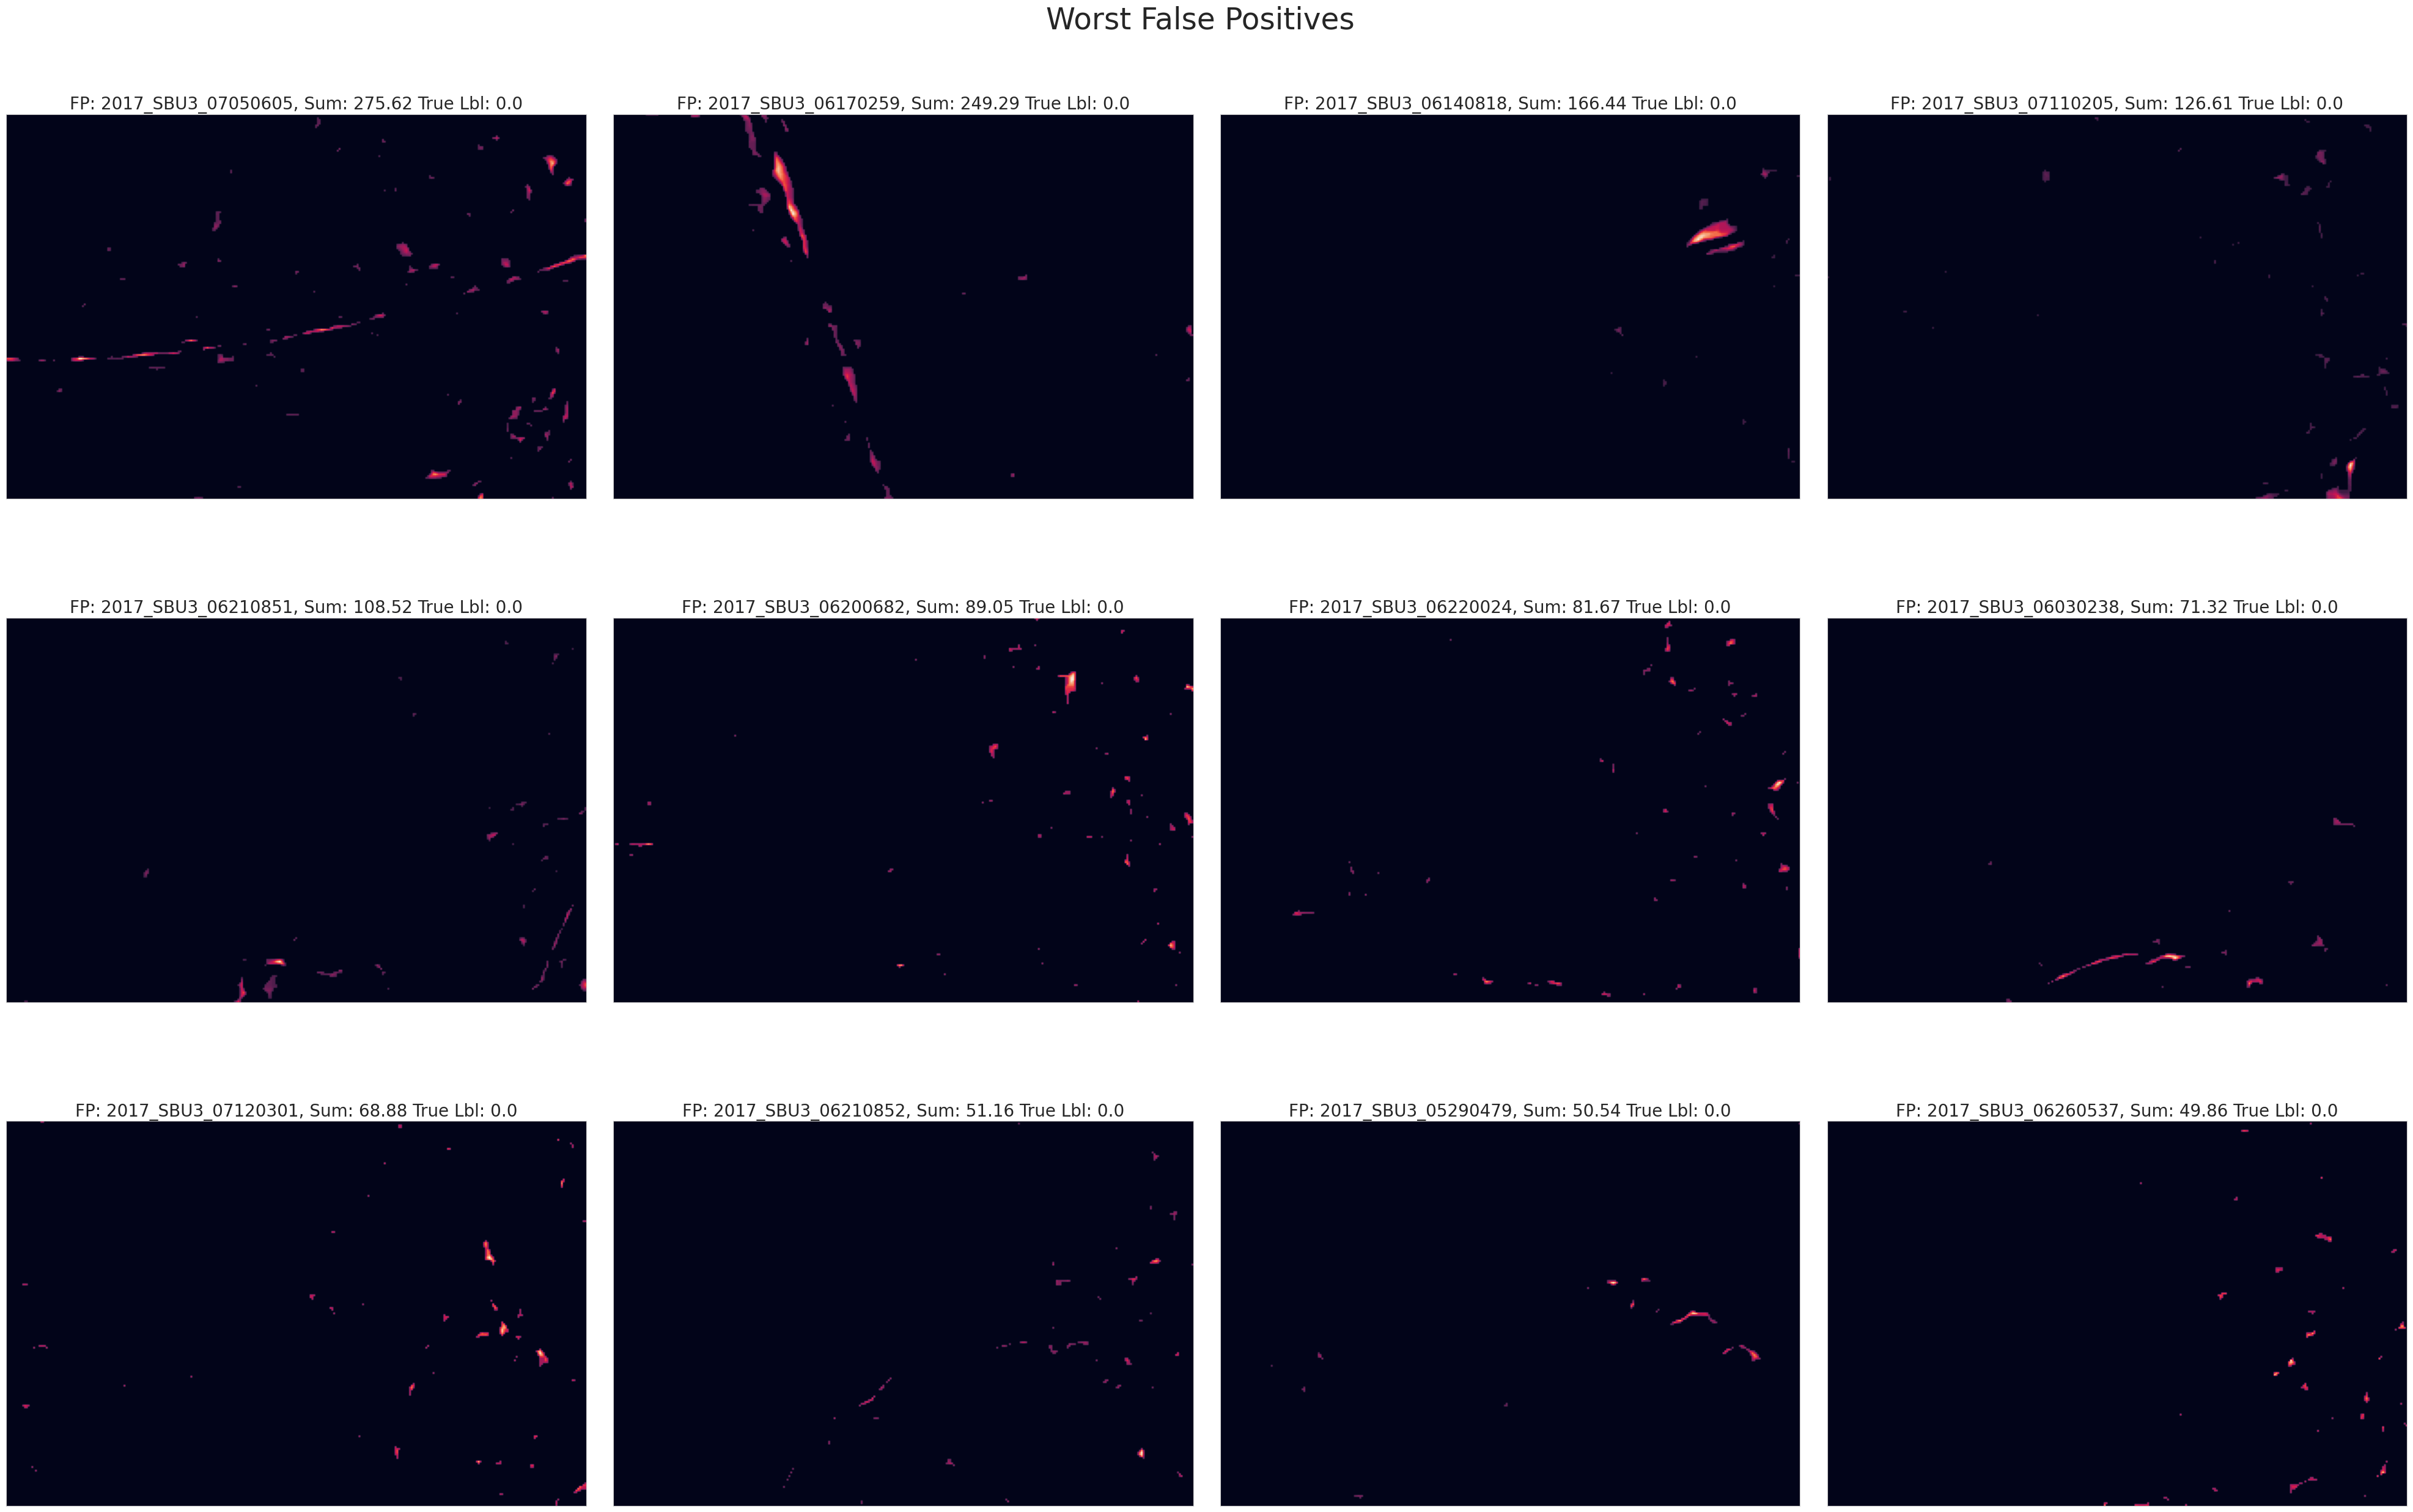

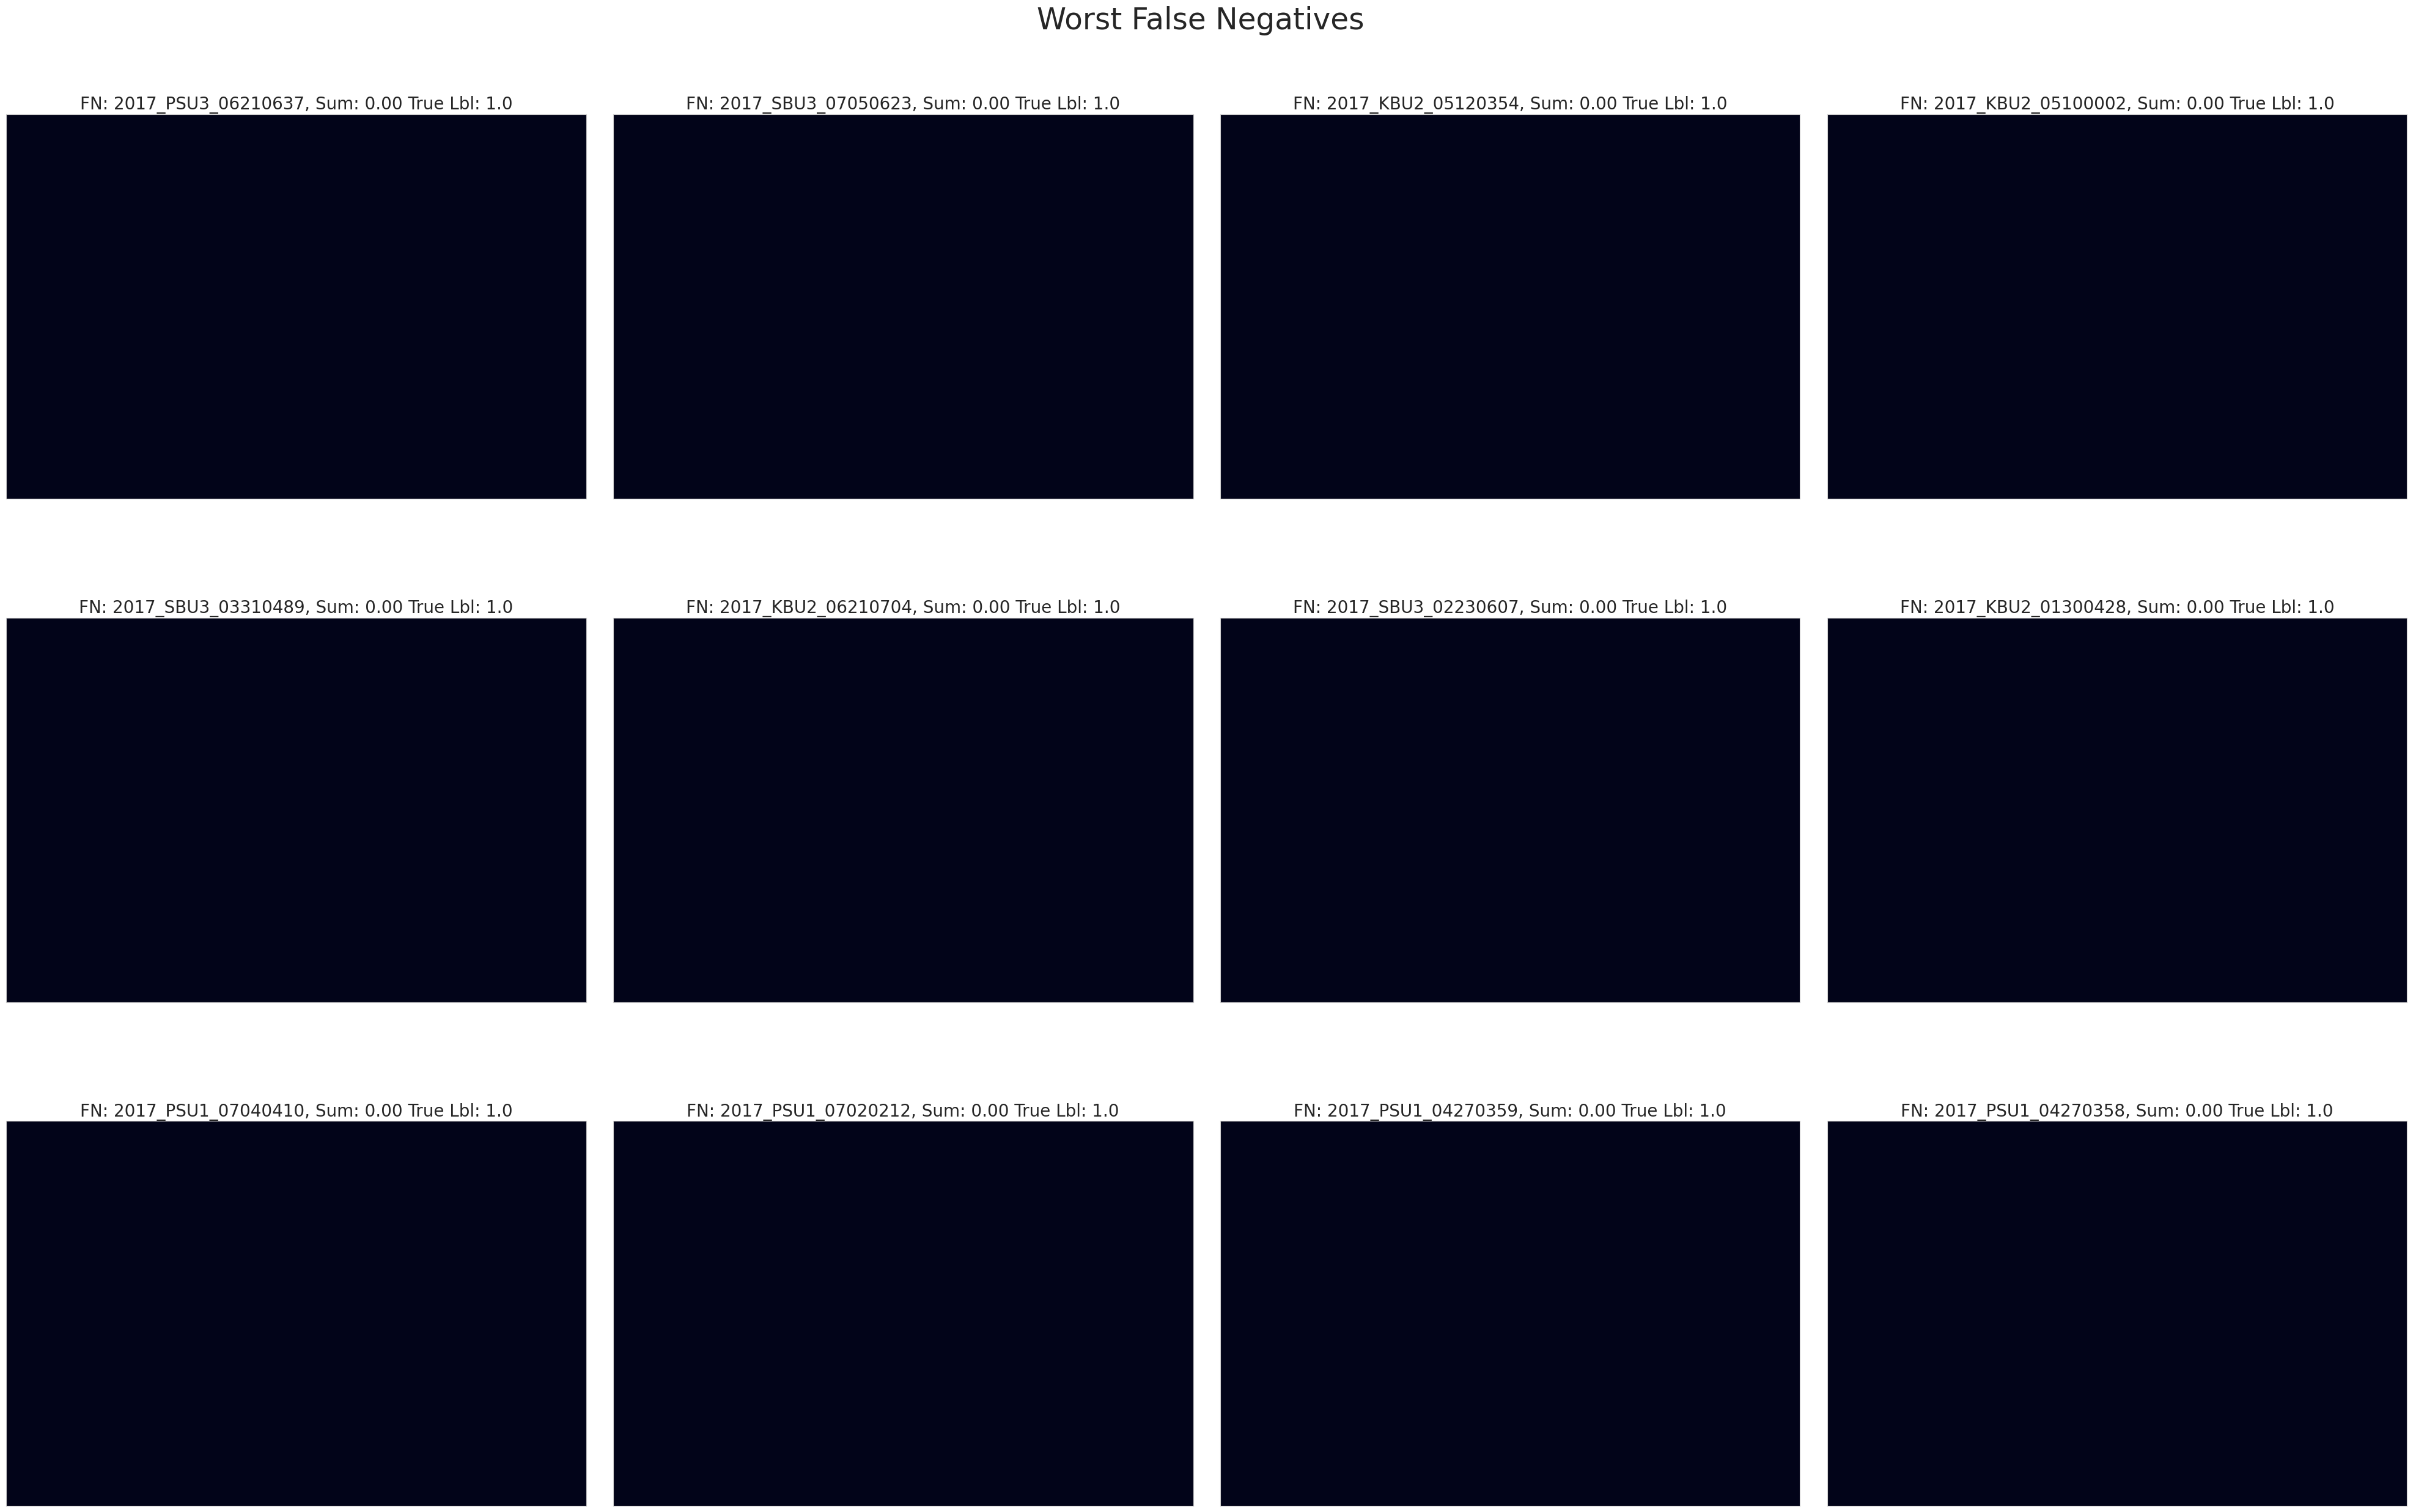

In [9]:

loaderParams = dict(
    lblValidationMode = "Manual",
    balanced = True,
    anomalyObviousness = "all",
    distinctCAETraining = False,
    colorMode = "RGB",
    random_state = 1,
    set = "all"
)
startState = dict(
    cameras = ["GBU1", "GBU4", "KBU2", "PSU1", "PSU2", "PSU3", "SGN1", "SBU3"],
    balanced = True,
    distinctCAETraining = False,
    gaussianFilterSize = 5,
    gaussianFilterSigma = 5,
    filter = "MinFilter", #["MinFilter", "GaussianFilter"]
    minFilterKernelSize = 4,
    zeroThreshold = 0.2, # uniform dist on loc, loc+scale -> uniform(loc, scale) #threshold for zeroing out the image
    sumThreshold = 20,
    lossFn = "L1"
)

settings = [startState]
evaluateAndPlotSettings(settings, checkPoint=CheckPoints.bestGlobal)

